In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR


! pip install torchsummary
from torchsummary import summary

%matplotlib inline


In [2]:

# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)), 
                                       transforms.ColorJitter(brightness=0.40, contrast=0.4, saturation=0.40, hue=0.1),
                                       transforms.RandomAffine(degrees=7, shear=10, translate=(0.1, 0.1), scale=(0.8, 1.2)),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# The model

In [6]:
from model import Net

# Training and Testing
Looking at logs can be boring, so we'll introduce tqdm progressbar to get cooler logs.

Let's write train and test functions

In [7]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

lambda_1 = 0.01


# L1 Norm
def train(model, device, train_loader, optimizer, epoch, L1=False):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)

    # if using L1 regularization
    l1 = 1 if L1 else 0

    if l1:
      for p in model.parameters():
        l1 += torch.norm(p)

    loss += lambda_1 * l1
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our models


In [8]:
norm_options = ["BN", "GN", "LN"]

metrics = {}

for norm in norm_options:
  model = Net(norm).to(device)
  print(f"Norm Type - { norm }")

  # print summary for norm type
  summary(model, input_size=(1, 28, 28))

  train_losses = []
  test_losses = []
  train_acc = []
  test_acc = []

  lambda_1 = 0.01

  EPOCHS = 20

  model =  Net(norm).to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  scheduler = StepLR(optimizer, step_size=8, gamma=0.1)

  
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch)

      # use L1 if norm is BN
      L1 = 1 if norm == "BN" else 0

      train(model, device, train_loader, optimizer, epoch, L1=L1)
      scheduler.step()
      test(model, device, test_loader)
  

  metrics[norm] = [train_losses, test_losses, train_acc, test_acc]



  0%|          | 0/469 [00:00<?, ?it/s]

Norm Type - BN
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           1,800
              ReLU-6           [-1, 20, 24, 24]               0
       BatchNorm2d-7           [-1, 20, 24, 24]              40
           Dropout-8           [-1, 20, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             200
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14    

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.6208932399749756 Batch_id=468 Accuracy=77.56: 100%|██████████| 469/469 [00:32<00:00, 14.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1000, Accuracy: 9703/10000 (97.03%)

EPOCH: 1


Loss=0.5320336818695068 Batch_id=468 Accuracy=94.80: 100%|██████████| 469/469 [00:32<00:00, 14.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0450, Accuracy: 9861/10000 (98.61%)

EPOCH: 2


Loss=0.5550783276557922 Batch_id=468 Accuracy=95.95: 100%|██████████| 469/469 [00:32<00:00, 14.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0400, Accuracy: 9882/10000 (98.82%)

EPOCH: 3


Loss=0.5015347599983215 Batch_id=468 Accuracy=96.43: 100%|██████████| 469/469 [00:32<00:00, 14.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0422, Accuracy: 9875/10000 (98.75%)

EPOCH: 4


Loss=0.4294256865978241 Batch_id=468 Accuracy=96.82: 100%|██████████| 469/469 [00:32<00:00, 14.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0398, Accuracy: 9871/10000 (98.71%)

EPOCH: 5


Loss=0.4169709086418152 Batch_id=468 Accuracy=96.84: 100%|██████████| 469/469 [00:32<00:00, 14.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0375, Accuracy: 9883/10000 (98.83%)

EPOCH: 6


Loss=0.3904167413711548 Batch_id=468 Accuracy=96.90: 100%|██████████| 469/469 [00:32<00:00, 14.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0406, Accuracy: 9871/10000 (98.71%)

EPOCH: 7


Loss=0.3867461085319519 Batch_id=468 Accuracy=97.03: 100%|██████████| 469/469 [00:32<00:00, 14.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0409, Accuracy: 9869/10000 (98.69%)

EPOCH: 8


Loss=0.37511834502220154 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:32<00:00, 14.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9928/10000 (99.28%)

EPOCH: 9


Loss=0.33115777373313904 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:32<00:00, 14.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9931/10000 (99.31%)

EPOCH: 10


Loss=0.3139360249042511 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:32<00:00, 14.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9939/10000 (99.39%)

EPOCH: 11


Loss=0.30956166982650757 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:32<00:00, 14.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9930/10000 (99.30%)

EPOCH: 12


Loss=0.30039140582084656 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:32<00:00, 14.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9932/10000 (99.32%)

EPOCH: 13


Loss=0.2952764332294464 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:33<00:00, 14.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9922/10000 (99.22%)

EPOCH: 14


Loss=0.35827088356018066 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:32<00:00, 14.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9939/10000 (99.39%)

EPOCH: 15


Loss=0.3693081736564636 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:32<00:00, 14.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9930/10000 (99.30%)

EPOCH: 16


Loss=0.3324251174926758 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:32<00:00, 14.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9941/10000 (99.41%)

EPOCH: 17


Loss=0.2906118333339691 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:32<00:00, 14.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9940/10000 (99.40%)

EPOCH: 18


Loss=0.297531396150589 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:32<00:00, 14.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9935/10000 (99.35%)

EPOCH: 19


Loss=0.3622118830680847 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:32<00:00, 14.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9937/10000 (99.37%)

Norm Type - GN
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
         GroupNorm-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           1,800
              ReLU-6           [-1, 20, 24, 24]               0
         GroupNorm-7           [-1, 20, 24, 24]              40
           Dropout-8           [-1, 20, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             200
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
             ReLU-12           [-1, 16, 10, 10]               0
        GroupNorm-13    

Loss=0.21938706934452057 Batch_id=468 Accuracy=70.30: 100%|██████████| 469/469 [00:31<00:00, 14.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1151, Accuracy: 9703/10000 (97.03%)

EPOCH: 1


Loss=0.1856866329908371 Batch_id=468 Accuracy=94.40: 100%|██████████| 469/469 [00:31<00:00, 14.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0578, Accuracy: 9832/10000 (98.32%)

EPOCH: 2


Loss=0.06367472559213638 Batch_id=468 Accuracy=96.23: 100%|██████████| 469/469 [00:32<00:00, 14.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0476, Accuracy: 9850/10000 (98.50%)

EPOCH: 3


Loss=0.12009146809577942 Batch_id=468 Accuracy=96.88: 100%|██████████| 469/469 [00:32<00:00, 14.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0400, Accuracy: 9867/10000 (98.67%)

EPOCH: 4


Loss=0.15921467542648315 Batch_id=468 Accuracy=97.43: 100%|██████████| 469/469 [00:32<00:00, 14.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0344, Accuracy: 9887/10000 (98.87%)

EPOCH: 5


Loss=0.13119874894618988 Batch_id=468 Accuracy=97.66: 100%|██████████| 469/469 [00:32<00:00, 14.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9892/10000 (98.92%)

EPOCH: 6


Loss=0.062273383140563965 Batch_id=468 Accuracy=97.76: 100%|██████████| 469/469 [00:32<00:00, 14.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Accuracy: 9895/10000 (98.95%)

EPOCH: 7


Loss=0.07666122168302536 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:31<00:00, 14.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Accuracy: 9911/10000 (99.11%)

EPOCH: 8


Loss=0.0533013641834259 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:32<00:00, 14.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9932/10000 (99.32%)

EPOCH: 9


Loss=0.04092193767428398 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:32<00:00, 14.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9936/10000 (99.36%)

EPOCH: 10


Loss=0.09721442312002182 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:32<00:00, 14.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9932/10000 (99.32%)

EPOCH: 11


Loss=0.06814806908369064 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:32<00:00, 14.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9933/10000 (99.33%)

EPOCH: 12


Loss=0.09444253891706467 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:32<00:00, 14.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9934/10000 (99.34%)

EPOCH: 13


Loss=0.013319048099219799 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:32<00:00, 14.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9931/10000 (99.31%)

EPOCH: 14


Loss=0.03349817171692848 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:32<00:00, 14.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9933/10000 (99.33%)

EPOCH: 15


Loss=0.027532150968909264 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:32<00:00, 14.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9930/10000 (99.30%)

EPOCH: 16


Loss=0.01990325003862381 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:32<00:00, 14.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9932/10000 (99.32%)

EPOCH: 17


Loss=0.012264632619917393 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:32<00:00, 14.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9933/10000 (99.33%)

EPOCH: 18


Loss=0.05250595510005951 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:32<00:00, 14.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9934/10000 (99.34%)

EPOCH: 19


Loss=0.01380246877670288 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:32<00:00, 14.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9934/10000 (99.34%)

Norm Type - LN
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
         LayerNorm-3           [-1, 10, 26, 26]          13,520
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           1,800
              ReLU-6           [-1, 20, 24, 24]               0
         LayerNorm-7           [-1, 20, 24, 24]          23,040
           Dropout-8           [-1, 20, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             200
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
             ReLU-12           [-1, 16, 10, 10]               0
        LayerNorm-13    

Loss=0.2346414476633072 Batch_id=468 Accuracy=72.86: 100%|██████████| 469/469 [00:32<00:00, 14.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1258, Accuracy: 9677/10000 (96.77%)

EPOCH: 1


Loss=0.15100185573101044 Batch_id=468 Accuracy=95.48: 100%|██████████| 469/469 [00:32<00:00, 14.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0511, Accuracy: 9859/10000 (98.59%)

EPOCH: 2


Loss=0.1069115623831749 Batch_id=468 Accuracy=96.92: 100%|██████████| 469/469 [00:32<00:00, 14.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0434, Accuracy: 9875/10000 (98.75%)

EPOCH: 3


Loss=0.13726161420345306 Batch_id=468 Accuracy=97.40: 100%|██████████| 469/469 [00:32<00:00, 14.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9919/10000 (99.19%)

EPOCH: 4


Loss=0.053927261382341385 Batch_id=468 Accuracy=97.77: 100%|██████████| 469/469 [00:32<00:00, 14.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9917/10000 (99.17%)

EPOCH: 5


Loss=0.05580167472362518 Batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:32<00:00, 14.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0343, Accuracy: 9900/10000 (99.00%)

EPOCH: 6


Loss=0.027342453598976135 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:32<00:00, 14.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9921/10000 (99.21%)

EPOCH: 7


Loss=0.024364324286580086 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:32<00:00, 14.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 9904/10000 (99.04%)

EPOCH: 8


Loss=0.08056841045618057 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:31<00:00, 14.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9934/10000 (99.34%)

EPOCH: 9


Loss=0.06792270392179489 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:32<00:00, 14.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9934/10000 (99.34%)

EPOCH: 10


Loss=0.09603358060121536 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:32<00:00, 14.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9935/10000 (99.35%)

EPOCH: 11


Loss=0.09219980239868164 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:32<00:00, 14.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9932/10000 (99.32%)

EPOCH: 12


Loss=0.06757382303476334 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:32<00:00, 14.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9933/10000 (99.33%)

EPOCH: 13


Loss=0.037926267832517624 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:32<00:00, 14.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9934/10000 (99.34%)

EPOCH: 14


Loss=0.03304363042116165 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:32<00:00, 14.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9932/10000 (99.32%)

EPOCH: 15


Loss=0.007502276450395584 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:32<00:00, 14.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9941/10000 (99.41%)

EPOCH: 16


Loss=0.0031552270520478487 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:32<00:00, 14.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9940/10000 (99.40%)

EPOCH: 17


Loss=0.07710030674934387 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:32<00:00, 14.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9941/10000 (99.41%)

EPOCH: 18


Loss=0.024335438385605812 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:32<00:00, 14.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9942/10000 (99.42%)

EPOCH: 19


Loss=0.07537742704153061 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:32<00:00, 14.42it/s]



Test set: Average loss: 0.0187, Accuracy: 9940/10000 (99.40%)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


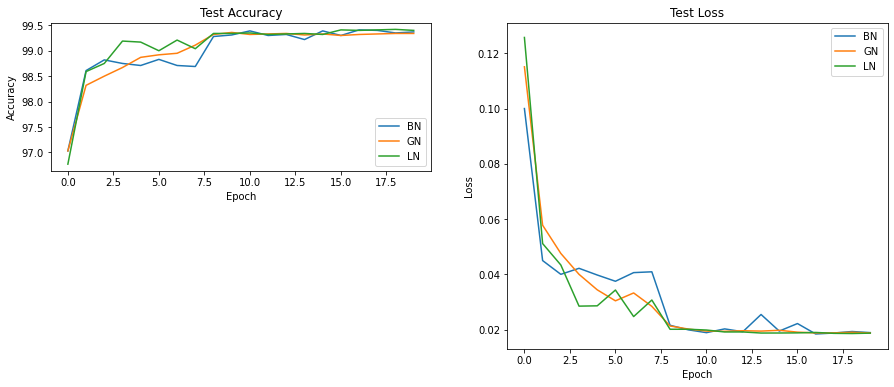

In [9]:
# fig, axs = plt.subplots(2,2,figsize=(15,10))
# axs[0, 0].plot(train_losses)
# axs[0, 0].set_title("Training Loss")
# axs[1, 0].plot(train_acc)
# axs[1, 0].set_title("Training Accuracy")
# axs[0, 1].plot(test_losses)
# axs[0, 1].set_title("Test Loss")
# axs[1, 1].plot(test_acc)
# axs[1, 1].set_title("Test Accuracy")

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 6]

for norm in norm_options:
  train_losses = metrics[norm][0]
  test_losses = metrics[norm][1]
  train_acc = metrics[norm][2]
  test_acc = metrics[norm][3]

  plt.subplot(2,2, 1)

  plt.plot(test_acc)
  plt.legend(norm_options)
  plt.title("Test Accuracy")

  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')

  plt.subplot(1,2,2)
  plt.plot(test_losses)
  plt.legend(norm_options)
  plt.title('Test Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

--------------- BN --------------- 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


--------------- GN --------------- --------------- LN --------------- 

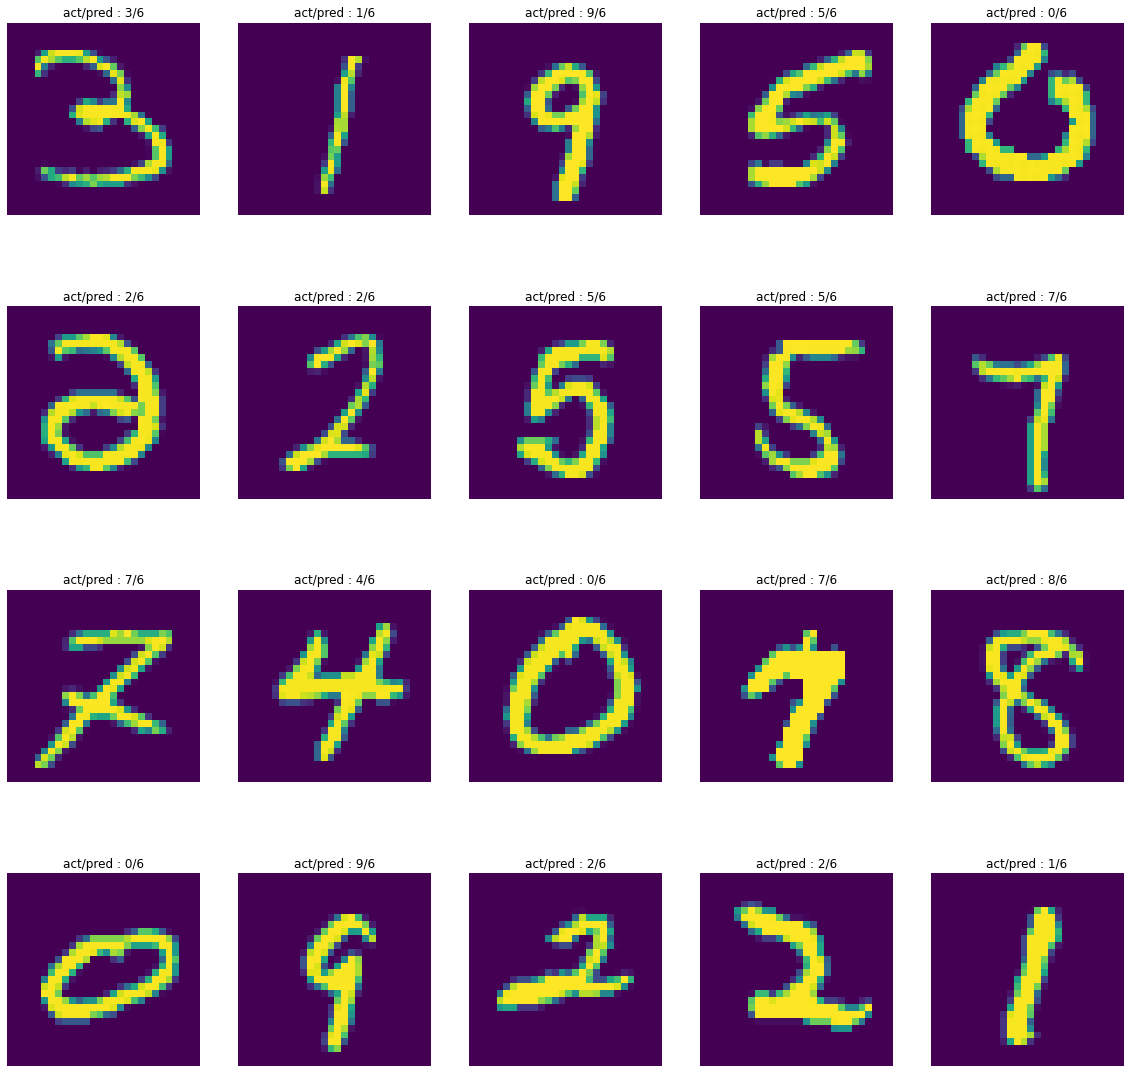

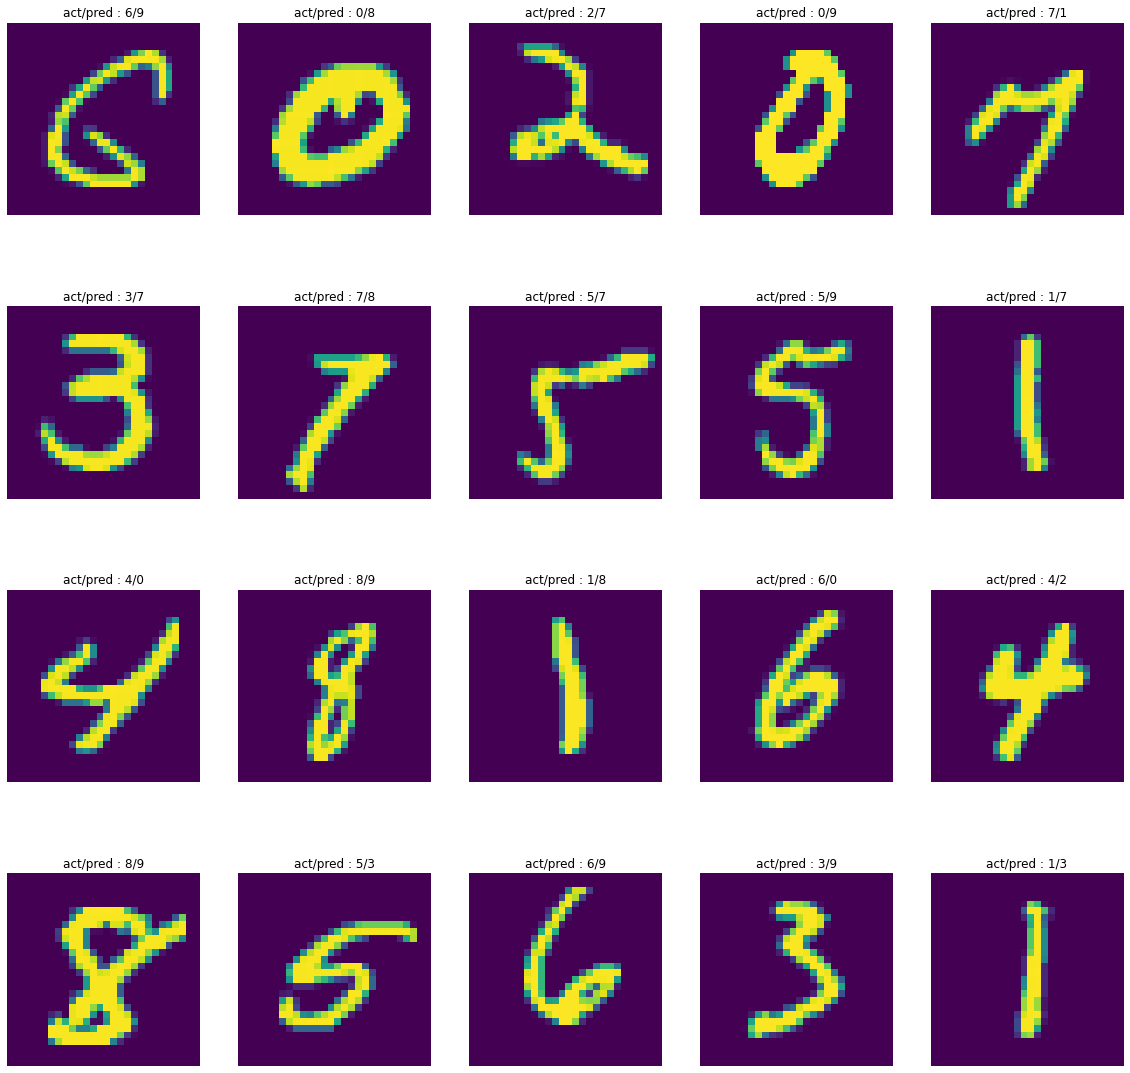

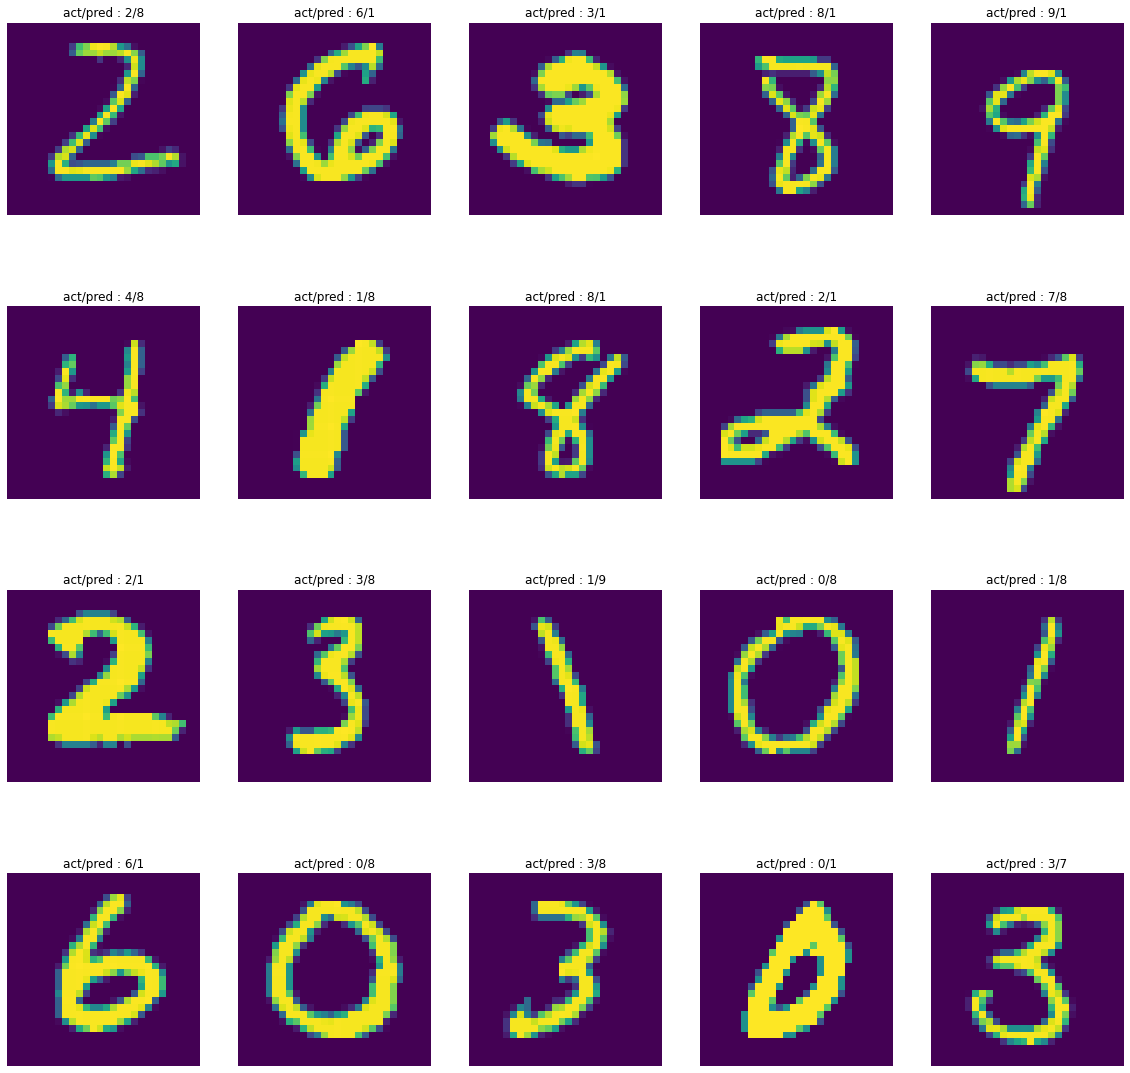

In [10]:
classes = ('0','1','2','3','4','5','6','7','8','9')

for norm in norm_options:

  print('-'*15,end=' ')
  print(norm,end=' ')
  print('-'*15,end = ' ')

  model = Net(norm).to(device)

  model.eval()

  figure = plt.figure(figsize=(20, 20))
  num_of_images = 20
  index = 1

  misclass_img_list = []
  untrans_img=[]

  with torch.no_grad():

      for data, target in test_loader:
          data, target = data.to(
              device), target.to(device)
          output = model(data)
          pred = output.argmax(dim=1, keepdim=True)
          act = target.view_as(pred)
          # since most of the bool vec is true (good problem to have) and switch (flip) the true to false and vice versa
          bool_vec = ~pred.eq(act)

          # now extract the index number from the tensor which has 'true'
          idx = list(
              np.where(bool_vec.cpu().numpy())[0])

          if idx:  # if not a blank list
              idx_list = idx
              # print(data[idx_list[0]].shape)
              if index < num_of_images+1:
                  plt.subplot(4, 5, index)
                  plt.axis('off')
                  titl = 'act/pred : ' + \
                      str(classes[target[idx[0]].cpu().item(
                      )]) + '/' + str(classes[pred[idx[0]].cpu().item()])
                  # prints the 1st index of each batch.
              
                  img = data[idx[0]].cpu()
                  untrans_img.append(img.squeeze_(0))
                  image = plt.imshow(img)
                  misclass_img_list.append(image)
                                    


                  plt.title(titl)
                  index += 1